# Final project for Big Data Lecture
#### Sentiment Analysis on IMDB Movie Reviews Dataset from Kaggle Competition
#### Link to dataset: https://www.kaggle.com/iarunava/imdb-movie-reviews-dataset
#### Author: Rafał Wójcik

# Structure of the project:
> ### 1. Description of the Dataset
> ### 2. Dataset cleaning
> ### 3. Transforming text data into sparse vector space
> ### 4. Training Linear Regression and Decision Tree models
> ### 5. Additional Features Calculation
> ### 6. Retraining the models
> ### 7. Evaluation of best model
> ### 8. Summary

In [ ]:
import os
import pandas as pd

#code taken from https://www.kaggle.com/desiredewaele/sentiment-analysis-on-imdb-reviews
path = os.getcwd() + "/aclImdb/"
positiveFiles = [x for x in os.listdir(path+"train/pos/") if x.endswith(".txt")]
negativeFiles = [x for x in os.listdir(path+"train/neg/") if x.endswith(".txt")]
testFiles = [x for x in os.listdir(path+"test/") if x.endswith(".txt")]

positiveReviews, negativeReviews = [], []
for pfile in positiveFiles:
    with open(path+"train/pos/"+pfile, encoding="latin1") as f:
        positiveReviews.append(f.read())
for nfile in negativeFiles:
    with open(path+"train/neg/"+nfile, encoding="latin1") as f:
        negativeReviews.append(f.read())
        
reviews = pd.concat([
    pd.DataFrame({"review":positiveReviews, "label":1, "file":positiveFiles}),
    pd.DataFrame({"review":negativeReviews, "label":0, "file":negativeFiles}),
], ignore_index=True)


reviews[['review', 'label']].to_csv('raw_dataset.csv', index=False)

<b> nessecary imports

In [ ]:
import os
import re
from re import sub
from time import time
import pandas as pd
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, auc, roc_curve
import matplotlib.pyplot as plt

### 1. Description of the Dataset
Analyzed Dataset comprised of 25000 movie reviews from site https://www.imdb.com. Each review from the original Kaggle Dataset was stored in separate .txt file, so in order to read them after downloading, there was additional code used (read_data.ipynb, attached to the project). After reading it, it was saved as 'raw_dataset.csv' file, and analyzed further. All of the reviews were labeled as either positive, or negative, based on the amount of stars that the movie achieved - all reviews with rating higher than 5 were labeled as positive (label 1 in the dataset), and all reviews with rating lesser or equal to 5 were labeled as negative (label 0 in the dataset). 

Code cell below presents first 10 rows from the dataset, along with their labels.

In [ ]:
file_raw = pd.read_csv('raw_dataset.csv').sample(frac=1, random_state=4).reset_index(drop=True)
file_raw.head(10)

,review,label
0,"Composed, elegant Carol (marvelously played by...",1
1,How could I best express my feelings about thi...,0
2,I saw this movie twice. I can't believe Pintil...,0
3,I first saw this film when i was about 13. It ...,1
4,This review may contain some SPOILERS.<br /><b...,0
5,Reviewing KAZAAM and saying it's a bad movie i...,0
6,There is so much that can be said about this f...,1
7,Probable reasons why so many people on this si...,0
8,I watched this movie last night and already I ...,0
9,Dr. Seuss would sure be mad right now if he wa...,0


It is clear, that during gathering phase of the dataset, some artifacts from the website were also gathered (such as sign '\<br \\>'). Such artifacts should be removed later on, to ensure that model trained on such data trains well, and don't use them as features. 

First review was labeled with 1, which means that it was positive. Full review in this observation looked like this:

In [ ]:
file_raw.review[0]

"Composed, elegant Carol (marvelously played by the beautiful Rebecca Brooke), her nice husband Eddie (likable David Houseman), Carol's wacky, constantly eating best gal pal Anna (delightfully essayed with infectious comic zeal by the adorable Chris Jordan), and Anna's hunky, amorous husband Pete (a typically fine Eric Edwards) are a quartet of liberated swingers who enjoy having frequent group sex with each other. Their usual routine gets disrupted when Carol's lonely, repressed, but still alluring widow mother Jennifer (a superbly moving performance by the lovely Jennifer Welles) drops by for a visit. Pretty soon Jennifer loosens up and becomes a willing participant in the swingers' blithely pleasurable and uninhibited carnal lifestyle, with everyone except Carol eager to seduce her. Writer/director Joe Sarno concocts a sharp, engrossing and perceptive examination of suburban angst and the limitations of the whole wild'n'easy 70's sexual revolution; Sarno turns traditional middle cla

Cell below presents amount of classes of response variable in given dataset.

In [ ]:
file_raw.label.value_counts()/len(file_raw)

1    0.5
0    0.5
Name: label, dtype: float64

The dataset is ideally balanced, with 12500 observations of class 1, and 12500 observations of class 0.

### 2. Dataset cleaning
In next step text data, which stands for only feature source in modeled problem was cleaned, to ensure that spoilt features like ones mentioned before do not go into training phase of the model. With use of cleaning function defined below, there were all non-alphanumerical signs removed from the dataset. The text was also transformed to string with use of str() function, to double-check that it will be a string, and all letters in the every sentence were lowered. Finally, all words in every sentence were stemmed with use of Snowball Stemmer from nltk package. Stemming have been used to reduce dimensionality of the transformed sentence-vectors, by reducing all words to their basic structure. Sentence vectors will be calcuated in section 3

In [ ]:
def cleaning(text, stemmer):
    '''
    Cleaning the dataset from non-alphanumerical signs, and stemming all words
    '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"<br />", " ", text)
    text = re.sub(r"[^A-Za-z'\!\?]+", " ", text)
    text_split = text.split()
    return ' '.join(list(map(stemmer.stem, text_split)))

stemmer = SnowballStemmer(language='english')

Cell below presents how cleaning function will change first review

In [ ]:
print("First review from the dataset before cleaning and stemming:")
print(file_raw.head(1).review[0])
print("\n\nFirst review from the dataset after cleaning and stemming:")
print(file_raw.head(1).review.apply(lambda x: cleaning(x, stemmer))[0])

First review from the dataset before cleaning and stemming:
Composed, elegant Carol (marvelously played by the beautiful Rebecca Brooke), her nice husband Eddie (likable David Houseman), Carol's wacky, constantly eating best gal pal Anna (delightfully essayed with infectious comic zeal by the adorable Chris Jordan), and Anna's hunky, amorous husband Pete (a typically fine Eric Edwards) are a quartet of liberated swingers who enjoy having frequent group sex with each other. Their usual routine gets disrupted when Carol's lonely, repressed, but still alluring widow mother Jennifer (a superbly moving performance by the lovely Jennifer Welles) drops by for a visit. Pretty soon Jennifer loosens up and becomes a willing participant in the swingers' blithely pleasurable and uninhibited carnal lifestyle, with everyone except Carol eager to seduce her. Writer/director Joe Sarno concocts a sharp, engrossing and perceptive examination of suburban angst and the limitations of the whole wild'n'easy

<b> Cleaning all sentences

In [ ]:
t = time()
file_cleaned = file_raw.copy()
file_cleaned.review = file_cleaned.review.apply(lambda x: ' '.join(list(map(stemmer.stem, x.split()))))
print('Time to clean everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean everything: 0.89 mins


### 3. Transforming text data into sparse vector feature space
To obtain features for the model from cleaned sentences, there was technique called term frequency-inverse document frequency used. With it's use, every sentence have been transformed into n-dimensional vector, were n was the size of vocabulary created based on given dataset (which was equal to all unique words present in given dataset, in case of splitting the next into separate words). On every position of this vector there was either 0 or calculated tf-idf score, depending of wether corresponding word to such position was present in the sentence. Furthermore, every tf-idf score was calculated based on term frequency of given word, multiplied by it's inverse document frequency score. With such technique, all unique words for given sentence achieved higher scores than words common for whole corpus. Formula below presents how score for every word in every sentence was calculated.

$tfidf(t) = tf(t, d) \cdot log({n(t) \over df(t)}) + 1$,

where:

tf(t, d) - term frequency of given word t in document (sentence) d

n - total number of documents in given dataset

df(t) - number of documents with word t

In [ ]:
X = file_cleaned.copy().review
y = file_cleaned.copy().label

corpus = X
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

After the transformation, X vector of sentences was transformed from one dimensional  vector with 25000 sentences, to 25000x71029 matrix with 71029 features. Every row in such matrix represented one sentence, and every column represented feature with score that indicated if corresponding word was present in the sentence, and how unique it was for it.

In [ ]:
file_cleaned.copy().review.shape, X.shape

((25000,), (25000, 71029))

### 4. Training Linear Regression and Decision Tree models
Finally, there were two models trained on task of classifying, whether sentiment of given review was positive or negative based on obtained feature vectors. Chosen models included Logistic Regression, and Decision Tree with entropy as split criterion. Before training the model, dataset was split into training and test datasets. Random seed of such split was set, to ensure that all further models will be evaluated on the same dataset. Accuracy was chosen as metrics for choosing the best model, as the classes in the dataset were balanced.

<b> Logistic Regression model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, stratify=y, random_state=44)

model1 = LogisticRegression(solver='lbfgs', max_iter=1000)
model1.fit(X_train, y_train)
model1.score(X_train, y_train), model1.score(X_test,y_test)

(0.9268571428571428, 0.8798666666666667)

<b> Decision Tree model

In [ ]:
model2 = DecisionTreeClassifier(min_samples_leaf=100, criterion='entropy')
model2.fit(X_train, y_train)
model2.score(X_train, y_train), model2.score(X_test,y_test)

(0.7629142857142858, 0.7206666666666667)

Better in terms of accuracy was Logistic Regression model. One of reasons might be, that for sparse features, which have lots of dimensions, and most of their values are zeroes, it might be hard for a decision tree to find optimal split, and approximate such dataset with well defined split points.

### 5. Additional Features Calculation
In next steps, there were additional features generated, also based on tf-idf technique, to check if they could improve model's performances. Apart from the features created in previous step, there were new vectors generated, with sparse vectors calculated for ngrams of characters (between 2 and 5 letters), for every word. This means, that every word was split into minimally chunks of 2 letters, and maximum 5 letters, so word 'beautiful' could have been split into tokens 'beauti' and 'ful'.


In [ ]:
X = file_cleaned.copy().review
y = file_cleaned.copy().label

corpus = X.copy()
vectorizer = TfidfVectorizer()

vectorizer2 = TfidfVectorizer(analyzer='char',
                              ngram_range={2,5},
                              max_features=3000)
X_word = vectorizer.fit_transform(corpus)
X_char = vectorizer2.fit_transform(corpus)

X = hstack([X_word, X_char])

After such transformations there were new 3000 features created, indicating if given sentence contained particular n-grams of characters, with their calculated tf-idf scores. Presumably, it could give additional information to the model and improve it's performance, though on the other hand it could also worsen it's performance, if the features turn out not to be informative.

In [ ]:
file_cleaned.copy().review.shape, X_word.shape, X_char.shape, X.shape

((25000,), (25000, 71029), (25000, 3000), (25000, 74029))

# 6. Retraining the models
After creation of additional features, both model's from part 4 of the project were retrained, to see how new features would affect their performance. 

<b> Logistic Regression model

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, train_size = 0.7, stratify=y, random_state=44)

model3 = LogisticRegression(solver='lbfgs', max_iter=1000)
model3.fit(X_train2, y_train2)
model3.score(X_train2, y_train2), model3.score(X_test2,y_test2)

(0.9275428571428571, 0.8817333333333334)

<b> Decision Tree model

In [ ]:
model4 = DecisionTreeClassifier(min_samples_leaf=100, criterion='entropy')
model4.fit(X_train, y_train)
model4.score(X_train, y_train), model4.score(X_test,y_test)

(0.7629142857142858, 0.7206666666666667)

For both model's additional features improved just a bit accuracies on training dataset, but also worsened slightly accuracies on test set. It could indicate that adding such specific features to model, as presence of certain ngrams in given sentence, might cause it to overfit to training dataset. After all these steps being complete, Logistic Regression model was chosen as better performing model for given problem.

### 7. Further evaluation of best model
To evaluate further the best classifier out of trained in previous steps, there was confusion matrix calculated, along with model's precision, recall, F1-score, and AUC value for each model.

In [ ]:
train_predictions = model1.predict(X_train)
train_proba = model1.predict_proba(X_train)[:,1]
test_predictions = model1.predict(X_test)
test_proba = model1.predict_proba(X_test)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, train_proba, pos_label=1)
auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_proba, pos_label=1)
auc_test = auc(fpr_test, tpr_test)

print('Confusion matrix')
display(pd.DataFrame(confusion_matrix(test_predictions, y_test)))
print('\n\n\nScores of the model')
display(pd.DataFrame(zip([model1.score(X_train, y_train), model1.score(X_test, y_test)],
                [precision_score(train_predictions, y_train), precision_score(test_predictions, y_test)],
                [recall_score(train_predictions, y_train), recall_score(test_predictions, y_test)],
                [f1_score(train_predictions, y_train), f1_score(test_predictions, y_test)],
                [auc_train, auc_test]), 
             columns=['accuracy', 'precision', 'recall', 'F1', 'AUC'],
             index=['train', 'test']))

Confusion matrix


,0,1
0,3262,413
1,488,3337





Scores of the model


,accuracy,precision,recall,F1,AUC
train,0.926857,0.932686,0.921939,0.927281,0.978631
test,0.879867,0.889867,0.872418,0.881056,0.949662


The model discriminated both classes with similar accuracy, and all given metrics were relatively high. Precision equal to 0.89 on test dataset indicated, that the model discriminated between negative and positive classes well. Recall equal to 0.87 indicated that the model classified 87% of all positive classes in the test dataset correctly. AUC of given model was also very high both on training and test datasets, which indicates that it distinguished between positive and negative classes very well. All metrics were slightly lower for test dataset, which might indicate little overfitting to the training dataset, but the difference was acceptable.

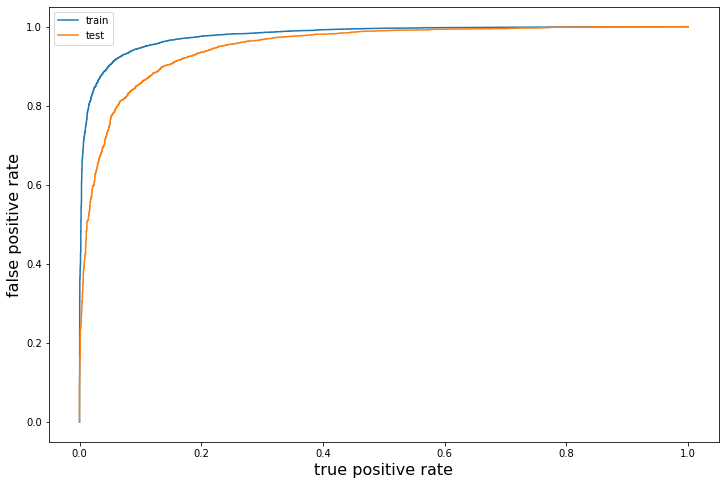

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(fpr_train, tpr_train, label='train')
plt.plot(fpr_test, tpr_test, label='test')
plt.xlabel('true positive rate', fontsize=16)
plt.ylabel('false positive rate', fontsize=16)
plt.legend()

### 8. Summary
In this project, there has been sentiment analysis performed on IMDB Movie reviews dataset. One of the main challenges in modeling textual data is the fact, that it is unstructured, which means that the information from this data needs to be extracted, in order to allow any model to learn from it. First step of working on textual data is normalizing it, which includes cleaning all unnessecary, non textual symbols, and reducing all words to more basic structure. In this project, for reducing words to their basic structure there was stemming technique used. After these steps being complete, it was nessecary to encode numerically all sentences. One of common methods of representing numerically textual data, is the technique of vectorizing it with tf-idf transformation. Essentially, it encodes all sentences into n-dimensional feature space, based on the corpus of all sentences from the dataset, that is fed into such method. Further, this technique allowed to create useful features for trained models, which included Logistic Regression model, and Decision Tree model. Overall there were 4 classifiers trained, also on additional n-gram features, which turned out not to improve model's performance. Best in terms of accuracy on given dataset turned out to be Logistic Regression model, trained on tf-idf vectors based on words. Extracted features allowed to train it to classify 92% of reviews correctly in training dataset, and almost 88% of reviews correctly in test dataset. To evaluate the best model further, there were additional metrics calculated, and ROC curve visualized. Based on their values, and on AUC of the ROC curve plot it is visible, that the model performed well both on positive reviews, and negative ones, and both on test and traning datasets. It is important to mention, that analyzed dataset contained perfectly balanced classes, which could be also one of the reasons it learned that well.